## Acne detection using YOLOV8

In [1]:
!pip install -qq keras-cv

In [2]:
# import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
from keras import *
import keras_cv
from keras.optimizers import AdamW
from keras.callbacks import *

BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE

Using TensorFlow backend


### Preprocessing


In [3]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')

    boxes = []
    classes = []

    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])

            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])

            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)

            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)

    return img_path, classes, boxes


# a function for creating file paths list
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


class_ids = ['Acne']
class_mapping = {0: 'Acne'}

In [4]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):

    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)

    image_paths = []
    bbox = []
    classes = []

    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)

    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox



In [5]:
# applying the functions

train_img_paths,train_classes,train_bboxes = creating_files('/content/drive/MyDrive/data-2/train/images',
                                                            '/content/drive/MyDrive/data-2/train/labels')

In [6]:
# validation sets and test sets

valid_img_paths, valid_classes, valid_bboxes = creating_files('/content/drive/MyDrive/data-2/valid/images',
                                                              '/content/drive/MyDrive/data-2/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('/content/drive/MyDrive/data-2/test/images',
                                                           '/content/drive/MyDrive/data-2/test/labels')

### Creating datasets

In [7]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)

    return img


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }

    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

### Data loaders

In [8]:
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

###Visulization of the bounding boxes from the dataset

In [9]:
# visualize a sample from the dataset

def visualize_dataset(inputs,value_range,rows,cols,bounding_box_format):
  inputs = next(iter(inputs.take(1)))
  images,bounding_boxes = inputs[0],inputs[1]

  keras_cv.visualization.plot_bounding_box_gallery(
      images,
      value_range = value_range,
      rows = rows,
      cols = cols,
      y_true = bounding_boxes,
      scale = 6,
      font_scale = 0.8,
      line_thickness = 2,
      dpi = 100,
      bounding_box_format = bounding_box_format,
      class_mapping = class_mapping,
      true_color = (192,57,43)
  )

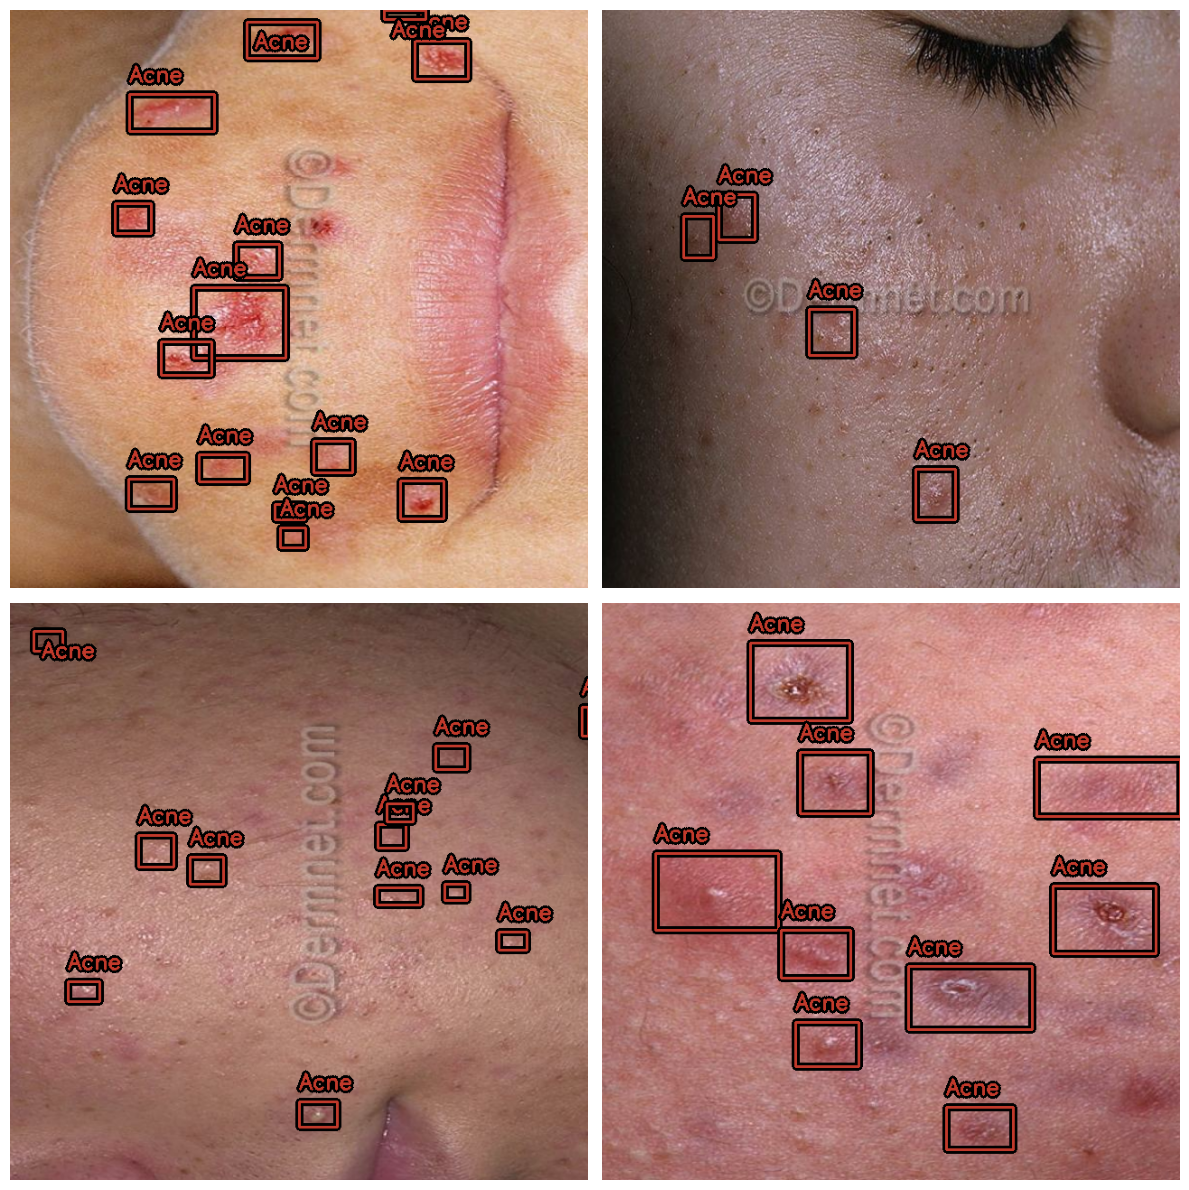

In [10]:
visualize_dataset(train_dataset,bounding_box_format = 'xyxy',value_range=(0,255),rows =2,cols=2)

## Modeling

In [11]:
# mirrored strategy

stg = tf.distribute.MirroredStrategy()


In [12]:
# yolo backbone

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone",
                                                          include_rescaling = True)

    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                                  bounding_box_format = "xyxy",
                                                  backbone = backbone,
                                                  fpn_depth = 5)

    optimizer = AdamW(learning_rate=0.0007, weight_decay=0.0009, global_clipnorm = 10.0)
    my_callbacks = [ModelCheckpoint('yolo_acne_detection.h5',
                                    monitor = 'val_loss',
                                    save_best_only = True,
                                    save_weights_only = True),
                    ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.01,
                                      patience=8,
                                      verbose=0,
                                      min_delta=0.001),
                    EarlyStopping(monitor='val_loss',
                                  patience=20)]


    YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')



### Training

In [13]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,
                        epochs = 140,
                        callbacks = my_callbacks)

Epoch 1/140
51/51 [==============================] - 106s 649ms/step - loss: 90.5778 - box_loss: 4.9088 - class_loss: 85.6689 - val_loss: 3914.6719 - val_box_loss: 4.1822 - val_class_loss: 3910.4895 - lr: 7.0000e-04
Epoch 2/140
51/51 [==============================] - 34s 634ms/step - loss: 30.8161 - box_loss: 3.8991 - class_loss: 26.9170 - val_loss: 29.6245 - val_box_loss: 4.0362 - val_class_loss: 25.5883 - lr: 7.0000e-04
Epoch 3/140
51/51 [==============================] - 33s 622ms/step - loss: 16.3966 - box_loss: 3.6491 - class_loss: 12.7475 - val_loss: 14.1147 - val_box_loss: 3.6769 - val_class_loss: 10.4378 - lr: 7.0000e-04
Epoch 4/140
51/51 [==============================] - 32s 597ms/step - loss: 9.9306 - box_loss: 3.5056 - class_loss: 6.4250 - val_loss: 10.1789 - val_box_loss: 3.8860 - val_class_loss: 6.2929 - lr: 7.0000e-04
Epoch 5/140
51/51 [==============================] - 34s 638ms/step - loss: 6.7740 - box_loss: 3.0434 - class_loss: 3.7305 - val_loss: 6.4443 - val_box_lo

### Evaluation

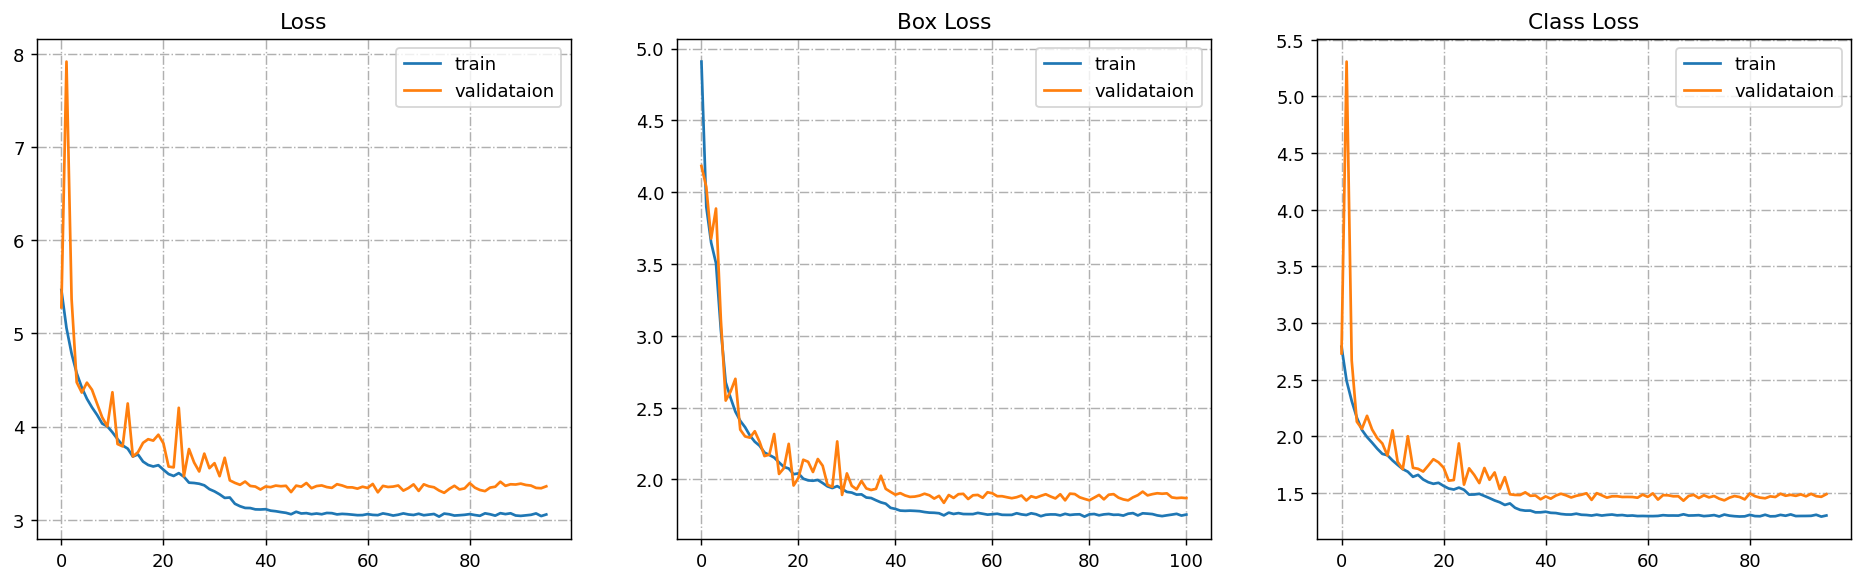

In [15]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][5:])
axs[0].plot(hist.history['val_loss'][5:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][5:])
axs[2].plot(hist.history['val_class_loss'][5:])
axs[2].legend(["train",  "validataion"])

### Test predictions

In [16]:
YOLOV8_model.evaluate(test_dataset)

3/3 [==============================] - 2s 179ms/step - loss: 3.5285 - box_loss: 2.0780 - class_loss: 1.4506


[3.528505325317383, 2.0779550075531006, 1.4505504369735718]

In [17]:
def visualize_predict_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images, verbose = 0)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )

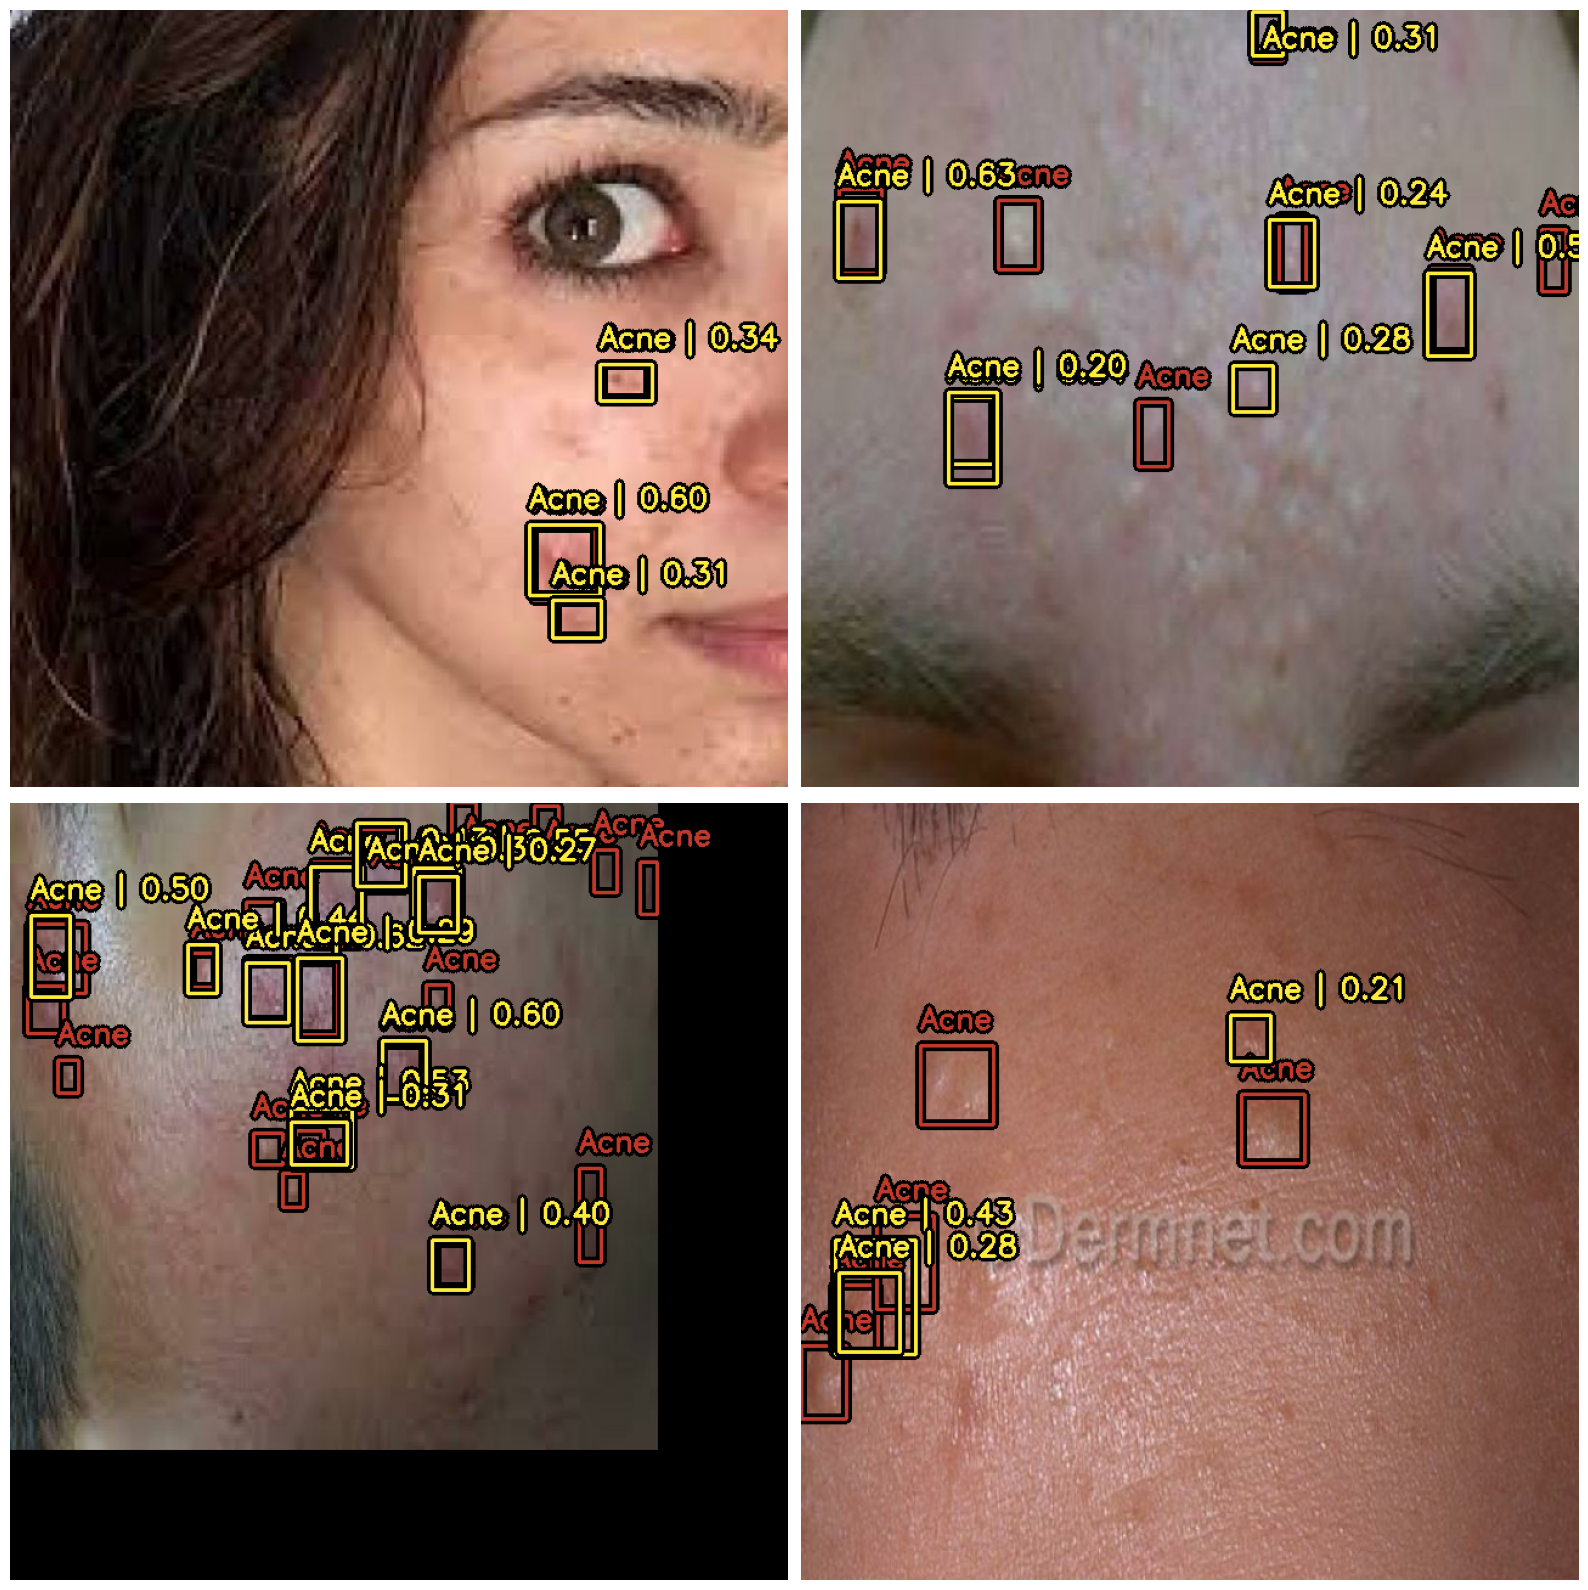

In [18]:
# red - ground true
# yellow - prediction

visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")

https://www.kaggle.com/code/banddaniel/acne-detection-w-kerascv-yolo-v8?scriptVersionId=161595230